# PCA SMOTE order difference
## Chongye Feng

### This notebook is to compare the order of PCA and SMOTE vs SMOTE then PCA.

-----
First, try PCA then SMOTE

In [1]:
import math
import torch
import numpy as np
import gpytorch
import pandas as pd
import os
from matplotlib import pyplot as plt
import sklearn
from sklearn.model_selection import KFold

%matplotlib inline
%load_ext autoreload
%autoreload 2

# check version number
import imblearn
print("imblearn version: ",imblearn.__version__)
from imblearn.over_sampling import SMOTE

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


from sklearn.metrics import confusion_matrix
import itertools

imblearn version:  0.11.0


In [2]:
# from sklearn 0.19.2 documentation:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar(shrink=0.7)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import torch


# Load data
uq_path = '../../../data/NEK_data_4Berkeley/NEK9/'
train_x_df = pd.read_csv(uq_path+'NEK9_inhibition_random_fold1_trainX.csv')
train_y_df= pd.read_csv(uq_path+"/NEK9_inhibition_random_fold1_trainY.csv")
test_x_df= pd.read_csv(uq_path+"/NEK9_inhibition_random_fold1_testX.csv")
test_y_df= pd.read_csv(uq_path+"/NEK9_inhibition_random_fold1_testY.csv")

# Concatenation of Training and Testing Feature Sets:
x_df = pd.concat([train_x_df, test_x_df])
# Feature Scaling using StandardScaler:
scaling = StandardScaler()
scaling.fit(x_df)
Scaled_data = scaling.transform(x_df)
train_scaled_data = scaling.transform(train_x_df)
test_scaled_data = scaling.transform(test_x_df)
# Print out the shape
print("-------------------------------------")
print("The shape of the dataset before PCA: ")
print(train_scaled_data.shape, test_scaled_data.shape)

# Apply PCA
principal = PCA(n_components=0.95) 
principal.fit(Scaled_data)
pca_train_x_df = principal.transform(train_scaled_data)
pca_test_x_df = principal.transform(test_scaled_data)
# Print out the shape
print("-------------------------------------")
print("The shape of the dataset after PCA: ")
print(pca_train_x_df.shape, pca_test_x_df.shape)

# SMOTE Initialization:
oversample = SMOTE()
# Applying SMOTE to the Training Data:
new_train_x_df, new_train_y_df = oversample.fit_resample(pca_train_x_df, train_y_df)

# Convert the feature arrays directly to PyTorch tensors and cast them to the appropriate type.
train_x_1 = torch.from_numpy(new_train_x_df).long()
test_x_1 = torch.from_numpy(pca_test_x_df).long()
# For the labels, which are pandas DataFrames, first convert them to numpy arrays, then cast to "long",
# and finally convert to PyTorch tensors.
train_y_1 = torch.from_numpy(new_train_y_df.to_numpy().astype("long")).reshape(-1)
test_y_1 = torch.from_numpy(test_y_df.to_numpy().astype("long")).reshape(-1)

# Print the shapes of the tensors to ensure they are correct.
print(f"Shape of training features tensor: {train_x_1.shape}")
print(f"Shape of training labels tensor: {train_y_1.shape}")

-------------------------------------
The shape of the dataset before PCA: 
(313, 306) (80, 306)
-------------------------------------
The shape of the dataset after PCA: 
(313, 52) (80, 52)
Shape of training features tensor: torch.Size([560, 52])
Shape of training labels tensor: torch.Size([560])


In [4]:
# SMOTE Initialization:
oversample = SMOTE()
# Applying SMOTE to the Training Data:
train_x_df_smote, train_y_df_smote = oversample.fit_resample(train_scaled_data, train_y_df)

# Apply PCA
principal = PCA(n_components=0.95) 
principal.fit(Scaled_data)
pca_train_x_df = principal.transform(train_x_df_smote)
pca_test_x_df = principal.transform(test_scaled_data)
# Print out the shape
print("-------------------------------------")
print("The shape of the dataset after PCA: ")
print(pca_train_x_df.shape, pca_test_x_df.shape)

# Convert the feature arrays directly to PyTorch tensors and cast them to the appropriate type.
train_x_2 = torch.from_numpy(pca_train_x_df).long()
test_x_2 = torch.from_numpy(pca_test_x_df).long()
# For the labels, which are pandas DataFrames, first convert them to numpy arrays, then cast to "long",
# and finally convert to PyTorch tensors.
train_y_2 = torch.from_numpy(train_y_df_smote.to_numpy().astype("long")).reshape(-1)
test_y_2 = torch.from_numpy(test_y_df.to_numpy().astype("long")).reshape(-1)

# Print the shapes of the tensors to ensure they are correct.
print(f"Shape of training features tensor: {train_x_2.shape}")
print(f"Shape of training labels tensor: {train_y_2.shape}")

-------------------------------------
The shape of the dataset after PCA: 
(560, 52) (80, 52)
Shape of training features tensor: torch.Size([560, 52])
Shape of training labels tensor: torch.Size([560])


In [5]:
# Construct a GP classification model

from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel

# We will use the simplest form of GP model, exact inference
class DirichletGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_classes):
        super(DirichletGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(batch_shape=torch.Size((num_classes,)))
        self.covar_module = ScaleKernel(
            RBFKernel(batch_shape=torch.Size((num_classes,))),
            batch_shape=torch.Size((num_classes,)),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
# we let the DirichletClassificationLikelihood compute the targets for us
likelihood_1 = DirichletClassificationLikelihood(train_y_1, learn_additional_noise=True)
model_1 = DirichletGPModel(train_x_1, likelihood_1.transformed_targets, likelihood_1, num_classes=likelihood_1.num_classes)

likelihood_2 = DirichletClassificationLikelihood(train_y_2, learn_additional_noise=True)
model_2 = DirichletGPModel(train_x_2, likelihood_2.transformed_targets, likelihood_2, num_classes=likelihood_2.num_classes)

In [6]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 300


# Find optimal model hyperparameters
model_1.train()
likelihood_1.train()

# Use the adam optimizer
optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll_1 = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_1, model_1)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer_1.zero_grad()
    # Output from model
    output_1 = model_1(train_x_1)
    # Calc loss and backprop gradients
    loss_1 = -mll_1(output_1, likelihood_1.transformed_targets).sum()
    loss_1.backward()
    if i % 5 == 0:
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss_1.item(),
            model_1.covar_module.base_kernel.lengthscale.mean().item(),
            model_1.likelihood.second_noise_covar.noise.mean().item()
        ))
    optimizer_1.step()

Iter 1/300 - Loss: 7.034   lengthscale: 0.693   noise: 0.693
Iter 6/300 - Loss: 6.291   lengthscale: 0.975   noise: 0.971
Iter 11/300 - Loss: 5.742   lengthscale: 1.321   noise: 1.286
Iter 16/300 - Loss: 5.330   lengthscale: 1.729   noise: 1.586
Iter 21/300 - Loss: 5.017   lengthscale: 2.202   noise: 1.803
Iter 26/300 - Loss: 4.781   lengthscale: 2.722   noise: 1.886
Iter 31/300 - Loss: 4.596   lengthscale: 3.259   noise: 1.831
Iter 36/300 - Loss: 4.431   lengthscale: 3.790   noise: 1.657
Iter 41/300 - Loss: 4.269   lengthscale: 4.305   noise: 1.399
Iter 46/300 - Loss: 4.112   lengthscale: 4.801   noise: 1.098
Iter 51/300 - Loss: 3.969   lengthscale: 5.269   noise: 0.801
Iter 56/300 - Loss: 3.847   lengthscale: 5.695   noise: 0.546
Iter 61/300 - Loss: 3.749   lengthscale: 6.073   noise: 0.357
Iter 66/300 - Loss: 3.675   lengthscale: 6.403   noise: 0.232
Iter 71/300 - Loss: 3.623   lengthscale: 6.687   noise: 0.156
Iter 76/300 - Loss: 3.587   lengthscale: 6.930   noise: 0.110
Iter 81/30

In [7]:
# Find optimal model hyperparameters
model_2.train()
likelihood_2.train()

# Use the adam optimizer
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll_2 = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_2, model_2)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer_2.zero_grad()
    # Output from model
    output_2 = model_2(train_x_2)
    # Calc loss and backprop gradients
    loss_2 = -mll_2(output_2, likelihood_2.transformed_targets).sum()
    loss_2.backward()
    if i % 5 == 0:
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss_2.item(),
            model_2.covar_module.base_kernel.lengthscale.mean().item(),
            model_2.likelihood.second_noise_covar.noise.mean().item()
        ))
    optimizer_2.step()

Iter 1/300 - Loss: 7.025   lengthscale: 0.693   noise: 0.693
Iter 6/300 - Loss: 6.283   lengthscale: 0.975   noise: 0.971
Iter 11/300 - Loss: 5.734   lengthscale: 1.320   noise: 1.286
Iter 16/300 - Loss: 5.325   lengthscale: 1.728   noise: 1.583
Iter 21/300 - Loss: 5.020   lengthscale: 2.200   noise: 1.795
Iter 26/300 - Loss: 4.790   lengthscale: 2.718   noise: 1.873
Iter 31/300 - Loss: 4.607   lengthscale: 3.254   noise: 1.814
Iter 36/300 - Loss: 4.440   lengthscale: 3.787   noise: 1.637
Iter 41/300 - Loss: 4.277   lengthscale: 4.308   noise: 1.378
Iter 46/300 - Loss: 4.119   lengthscale: 4.811   noise: 1.077
Iter 51/300 - Loss: 3.976   lengthscale: 5.285   noise: 0.782
Iter 56/300 - Loss: 3.855   lengthscale: 5.718   noise: 0.532
Iter 61/300 - Loss: 3.758   lengthscale: 6.100   noise: 0.346
Iter 66/300 - Loss: 3.685   lengthscale: 6.433   noise: 0.225
Iter 71/300 - Loss: 3.634   lengthscale: 6.719   noise: 0.151
Iter 76/300 - Loss: 3.600   lengthscale: 6.964   noise: 0.107
Iter 81/30

In [8]:
# Make predictions with the model

model_1.eval()
likelihood_1.eval()

with gpytorch.settings.fast_pred_var(), torch.no_grad():
    test_dist_1 = model_1(train_x_1)
    pred_means_1 = test_dist_1.loc
    observed_pred_1 = likelihood_1(model_1(train_x_1))
    
print(pred_means_1.numpy().shape)
print(pred_means_1.max(0)[1])

(2, 560)
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1,

/home/chongyef/miniconda3/envs/atom2024/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [9]:
model_2.eval()
likelihood_2.eval()

with gpytorch.settings.fast_pred_var(), torch.no_grad():
    test_dist_2 = model_2(train_x_2)
    pred_means_2 = test_dist_2.loc
    observed_pred_2 = likelihood_2(model_2(train_x_2))
    
print(pred_means_2.numpy().shape)
print(pred_means_2.max(0)[1])

(2, 560)
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1,

Confusion matrix, without normalization
[[276   4]
 [  0 280]]


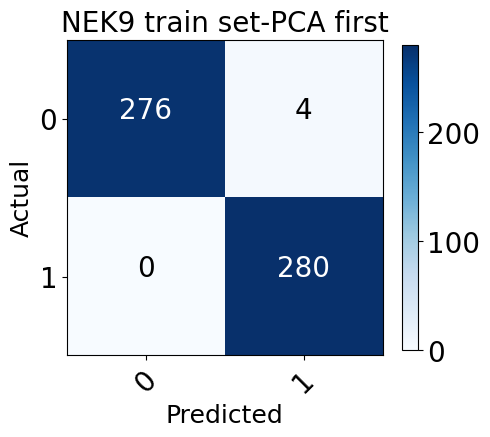

In [10]:
train_prediction_1 = model_1(train_x_1).loc.max(0)[1].numpy()
y_true_1 = new_train_y_df.values
y_pred_1 = train_prediction_1
train_cm = confusion_matrix(y_true_1, y_pred_1)
class_names = ["0","1"]

plt.rcParams.update({"font.size": 20})
label_font = {'size':'18'}  # Adjust to fit
ax = plt.figure(figsize=(5,5))
plt.title("NEK9 train set-PCA first",fontsize=20)
plot_confusion_matrix(train_cm, classes=class_names, normalize=False)
plt.xlabel("Predicted",fontdict=label_font);
plt.ylabel("Actual",fontdict=label_font);

Confusion matrix, without normalization
[[276   4]
 [  0 280]]


/home/chongyef/miniconda3/envs/atom2024/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


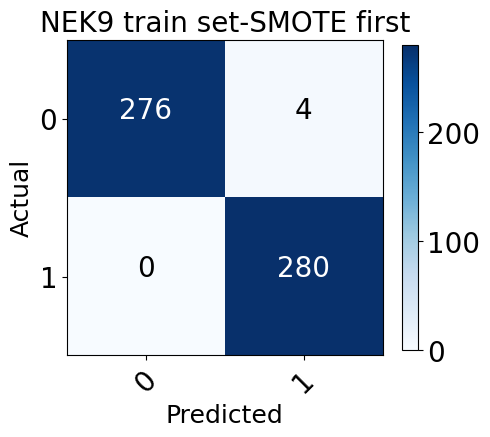

In [11]:
train_prediction_2 = model_2(train_x_2).loc.max(0)[1].numpy()
y_true_2 = train_y_df_smote.values
y_pred_2 = train_prediction_2
train_cm = confusion_matrix(y_true_2, y_pred_2)
class_names = ["0","1"]

plt.rcParams.update({"font.size": 20})
label_font = {'size':'18'}  # Adjust to fit
ax = plt.figure(figsize=(5,5))
plt.title("NEK9 train set-SMOTE first",fontsize=20)
plot_confusion_matrix(train_cm, classes=class_names, normalize=False)
plt.xlabel("Predicted",fontdict=label_font);
plt.ylabel("Actual",fontdict=label_font);

(2, 80)
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 1, 1, 0, 1, 1, 1])
Confusion matrix, without normalization
[[70  1]
 [ 2  7]]


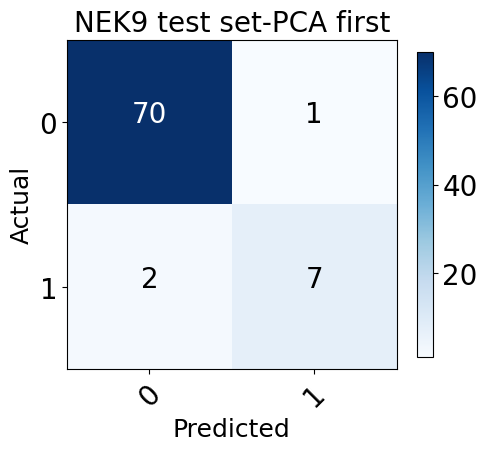

In [12]:
# Make predictions with the model

model_1.eval()
likelihood_1.eval()

with gpytorch.settings.fast_pred_var(), torch.no_grad():
    test_dist_1 = model_1(test_x_1)
    pred_means_1 = test_dist_1.loc
    observed_pred_1 = likelihood_1(model_1(test_x_1))
    
print(pred_means_1.numpy().shape)
print(pred_means_1.max(0)[1])

test_prediction_1 = model_1(test_x_1).loc.max(0)[1].numpy()

y_true_1 = test_y_df.values
y_pred_1 = test_prediction_1
test_cm = confusion_matrix(y_true_1, y_pred_1)
class_names = ["0","1"]

plt.rcParams.update({"font.size": 20})
label_font = {'size':'18'}  # Adjust to fit
ax = plt.figure(figsize=(5,5))
plt.title("NEK9 test set-PCA first",fontsize=20)
plot_confusion_matrix(test_cm, classes=class_names, normalize=False)
plt.xlabel("Predicted",fontdict=label_font);
plt.ylabel("Actual",fontdict=label_font);

(2, 80)
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 1, 1, 0, 1, 1, 1])
Confusion matrix, without normalization
[[70  1]
 [ 2  7]]


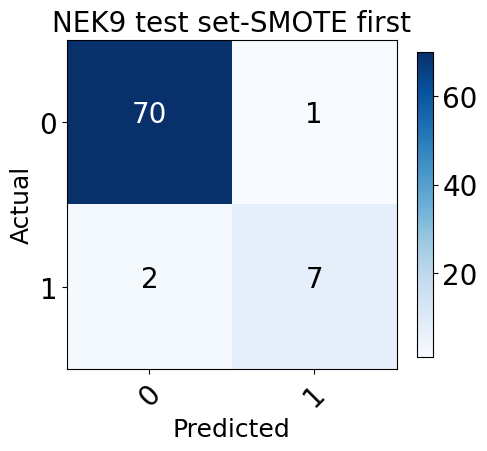

In [13]:
# Make predictions with the model

model_2.eval()
likelihood_2.eval()

with gpytorch.settings.fast_pred_var(), torch.no_grad():
    test_dist_2 = model_2(test_x_2)
    pred_means_2 = test_dist_2.loc
    observed_pred_2 = likelihood_2(model_2(test_x_2))
    
print(pred_means_2.numpy().shape)
print(pred_means_2.max(0)[1])

test_prediction_2 = model_2(test_x_2).loc.max(0)[1].numpy()

y_true_2 = test_y_df.values
y_pred_2 = test_prediction_2
test_cm = confusion_matrix(y_true_2, y_pred_2)
class_names = ["0","1"]

plt.rcParams.update({"font.size": 20})
label_font = {'size':'18'}  # Adjust to fit
ax = plt.figure(figsize=(5,5))
plt.title("NEK9 test set-SMOTE first",fontsize=20)
plot_confusion_matrix(test_cm, classes=class_names, normalize=False)
plt.xlabel("Predicted",fontdict=label_font);
plt.ylabel("Actual",fontdict=label_font);

(-0.5, 8.5, -0.5, 8.5)

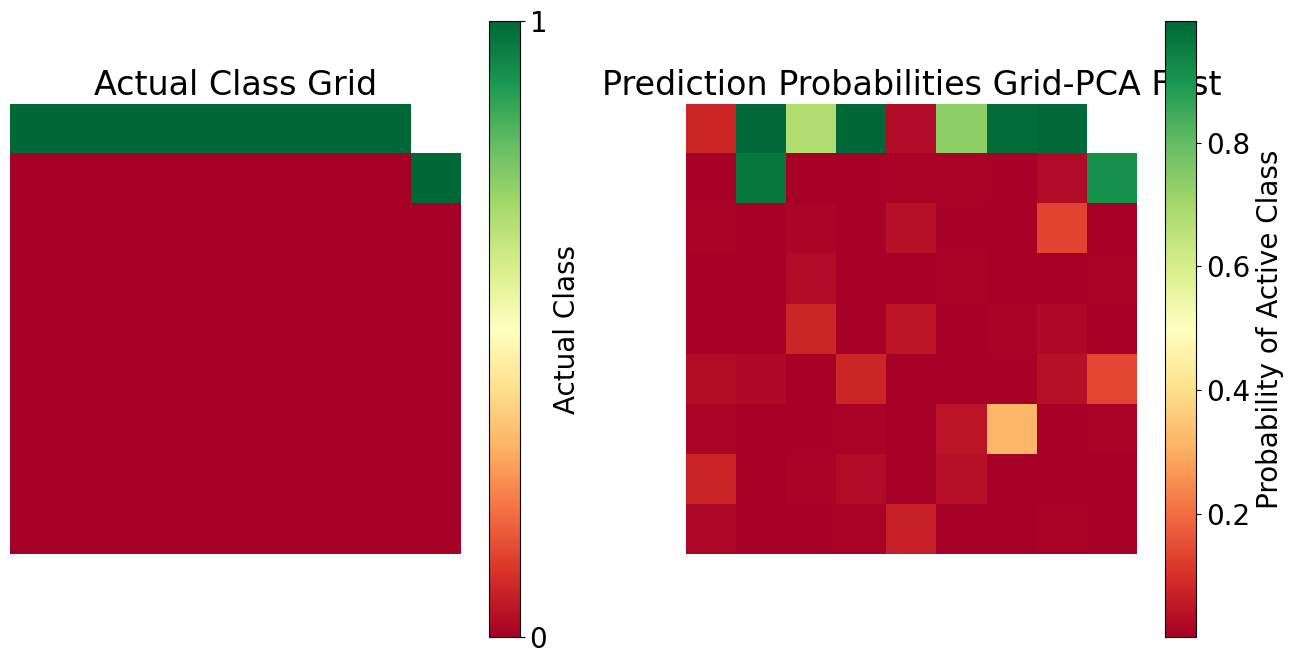

In [14]:
import matplotlib.pyplot as plt
import numpy as np

pred_samples_1 = test_dist_1.sample(torch.Size((256,))).exp()
probabilities_1 = (pred_samples_1 / pred_samples_1.sum(-2, keepdim=True)).mean(0)

# Assuming `y_true` contains the actual class labels and `probabilities` is your tensor
actual_classes_1 = np.array(y_true_1)  # Ensure it's a numpy array
probabilities_np_1 = probabilities_1.numpy()  # Assuming 'probabilities' is a tensor

# Calculate the side length of the grid for square arrangement
num_samples = actual_classes_1.shape[0]
side_length = int(np.ceil(np.sqrt(num_samples)))

# Prepare actual class grid data
actual_grid_data = np.full((side_length, side_length), np.nan)
actual_grid_data.flat[:num_samples] = actual_classes_1

# Prepare predicted probabilities grid data
active_probabilities = probabilities_np_1[1, :]  # Active class probabilities
prediction_grid_data = np.full((side_length, side_length), np.nan)
prediction_grid_data.flat[:num_samples] = active_probabilities

# Plotting both grids side by side
fig, axs = plt.subplots(1, 2, figsize=(16, 8), gridspec_kw={'width_ratios': [1, 1]})

# Plot actual class grid
im0 = axs[0].imshow(actual_grid_data, cmap='RdYlGn', origin='lower', aspect='equal')
fig.colorbar(im0, ax=axs[0], ticks=[0, 1], label='Actual Class')
axs[0].set_title('Actual Class Grid')
axs[0].axis('off')

# Plot prediction probabilities grid
im1 = axs[1].imshow(prediction_grid_data, cmap='RdYlGn', origin='lower', aspect='equal')
fig.colorbar(im1, ax=axs[1], label='Probability of Active Class')
axs[1].set_title('Prediction Probabilities Grid-PCA First')
axs[1].axis('off')

(-0.5, 8.5, -0.5, 8.5)

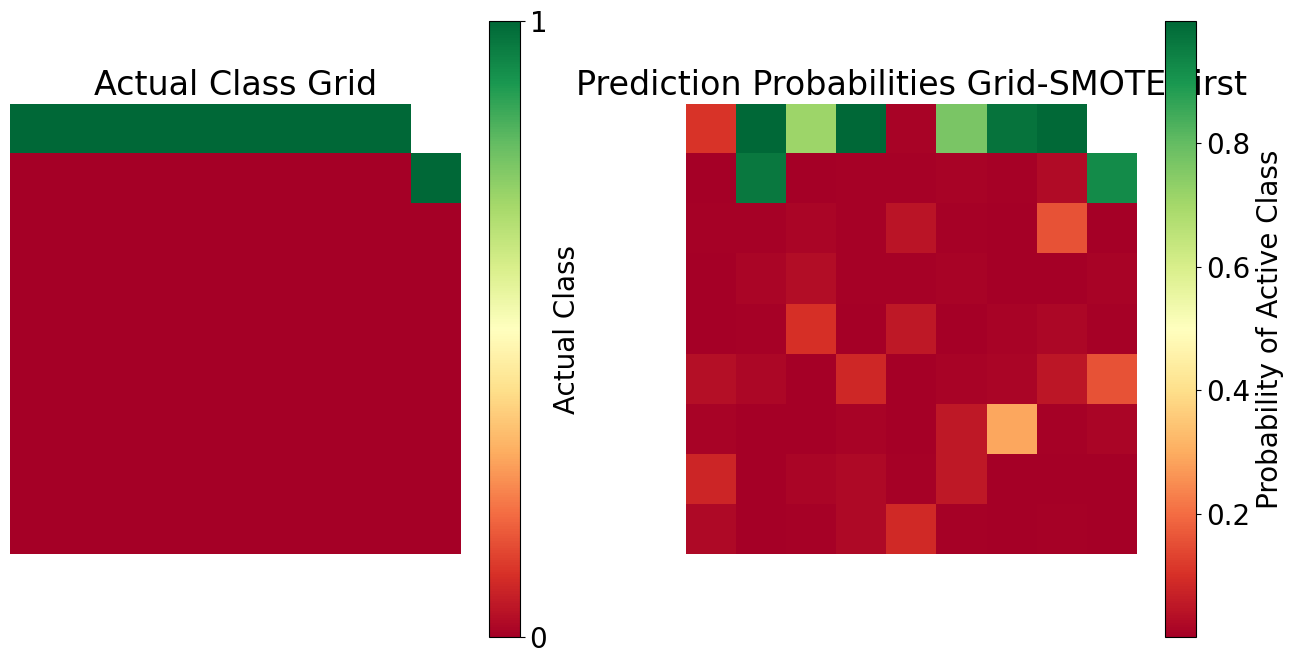

In [15]:
pred_samples_2 = test_dist_2.sample(torch.Size((256,))).exp()
probabilities_2 = (pred_samples_2 / pred_samples_2.sum(-2, keepdim=True)).mean(0)

# Assuming `y_true` contains the actual class labels and `probabilities` is your tensor
actual_classes_2 = np.array(y_true_1)  # Ensure it's a numpy array
probabilities_np_2 = probabilities_2.numpy()  # Assuming 'probabilities' is a tensor

# Calculate the side length of the grid for square arrangement
num_samples = actual_classes_2.shape[0]
side_length = int(np.ceil(np.sqrt(num_samples)))

# Prepare actual class grid data
actual_grid_data = np.full((side_length, side_length), np.nan)
actual_grid_data.flat[:num_samples] = actual_classes_2

# Prepare predicted probabilities grid data
active_probabilities = probabilities_np_2[1, :]  # Active class probabilities
prediction_grid_data = np.full((side_length, side_length), np.nan)
prediction_grid_data.flat[:num_samples] = active_probabilities

# Plotting both grids side by side
fig, axs = plt.subplots(1, 2, figsize=(16, 8), gridspec_kw={'width_ratios': [1, 1]})

# Plot actual class grid
im0 = axs[0].imshow(actual_grid_data, cmap='RdYlGn', origin='lower', aspect='equal')
fig.colorbar(im0, ax=axs[0], ticks=[0, 1], label='Actual Class')
axs[0].set_title('Actual Class Grid')
axs[0].axis('off')

# Plot prediction probabilities grid
im1 = axs[1].imshow(prediction_grid_data, cmap='RdYlGn', origin='lower', aspect='equal')
fig.colorbar(im1, ax=axs[1], label='Probability of Active Class')
axs[1].set_title('Prediction Probabilities Grid-SMOTE First')
axs[1].axis('off')

In [18]:
train_x_1[0]

tensor([-3, -2, -3, -3,  2, -2,  3, -2,  0, -3, -2,  0,  0,  2,  0,  0,  4, -2,
        -1,  0,  1,  1, -1,  1,  0,  0,  0,  1,  0,  0,  2,  0,  0, -1,  1,  0,
         0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])